In [1]:
import matplotlib.pyplot as plt
import torch
import yaml

from src.models.unet.unet_pl_module import UNetPLModule
from src.models.earthformer.earthformer_pl_module import EarthformerPLModule
from src.dataset.sevir_dataset import SEVIRTorchDataset
from src.visualization.colormaps import get_cmap

In [2]:
with open("configs/unet_2_channels.yaml", "r") as f:
    config_unet2 = yaml.safe_load(f)
    
with open("configs/unet_3_channels.yaml", "r") as f:
    config_unet3 = yaml.safe_load(f)

In [3]:
dataset2 = SEVIRTorchDataset(
    seq_len_in=config_unet2["dataset"]["seq_len_in"],
    seq_len_out=config_unet2["dataset"]["seq_len_out"],
    stride=config_unet2["dataset"]["stride"],
    sevir_root_dir=config_unet2["dataset"]["sevir_root_dir"],
    x_img_types=config_unet2["dataset"]["x_img_types"],
    y_img_types=config_unet2["dataset"]["y_img_types"],
    preprocess=config_unet2["dataset"]["preprocess"],
    normalization_method=config_unet2["dataset"]["normalization_method"],
    downsample=config_unet2["dataset"]["downsample"],
    upsample=config_unet2["dataset"]["upsample"],
    start_date=config_unet2["dataset"]["start_date"],
    end_date=config_unet2["dataset"]["end_date"]
)

dataset3 = SEVIRTorchDataset(
    seq_len_in=config_unet3["dataset"]["seq_len_in"],
    seq_len_out=config_unet3["dataset"]["seq_len_out"],
    stride=config_unet3["dataset"]["stride"],
    sevir_root_dir=config_unet3["dataset"]["sevir_root_dir"],
    x_img_types=config_unet3["dataset"]["x_img_types"],
    y_img_types=config_unet3["dataset"]["y_img_types"],
    preprocess=config_unet3["dataset"]["preprocess"],
    normalization_method=config_unet3["dataset"]["normalization_method"],
    downsample=config_unet3["dataset"]["downsample"],
    upsample=config_unet3["dataset"]["upsample"],
    start_date=config_unet3["dataset"]["start_date"],
    end_date=config_unet3["dataset"]["end_date"]
)

In [4]:
model_ef2 = EarthformerPLModule(
    total_num_steps=0,
    oc_file="configs/earthformer_2_channels.yaml"
)

model_ef3 = EarthformerPLModule(
    total_num_steps=0,
    oc_file="configs/earthformer_3_channels.yaml"
)

model_unet2 = UNetPLModule(
    **config_unet2["model"],
    device="cpu",
    denormalization_method=config_unet2["dataset"].get("normalize", None)
)

model_unet3 = UNetPLModule(
    **config_unet3["model"],
    device="cpu",
    denormalization_method=config_unet3["dataset"].get("normalize", None)
)

/home/datalab/miniconda3/envs/earthformer_filip/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
checkpoint = torch.load("logs/earthformer/2_channels_mse/checkpoints/epoch=11-step=75216.ckpt", map_location=torch.device("cpu"))
model_ef2.load_state_dict(checkpoint["state_dict"])
model_ef2.eval()

checkpoint = torch.load("logs/earthformer/3_channels_mse/checkpoints/epoch=10-step=68750.ckpt", map_location=torch.device("cpu"))
model_ef3.load_state_dict(checkpoint["state_dict"])
model_ef3.eval()

checkpoint = torch.load("logs/u-net/2_channels_mse/checkpoints/epoch=6-step=43876.ckpt", map_location=torch.device("cpu"))
model_unet2.load_state_dict(checkpoint["state_dict"])
model_unet2.eval()

checkpoint = torch.load("logs/u-net/3_channels_mse/checkpoints/epoch=3-step=25000.ckpt", map_location=torch.device("cpu"))
model_unet3.load_state_dict(checkpoint["state_dict"])
model_unet3.eval()

UNetPLModule(
  (unet): UNet(
    (in_conv): DoubleConvBlock(
      (double_conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): EncoderBlock(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConvBlock(
          (double_conv): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3):

In [6]:
inp2, target2 = dataset2[1670]  # 1600, 1645
inp3, target3 = dataset3[1670]

In [7]:
pred_ef2 = model_ef2.infer(inp2)
pred_ef3 = model_ef3.infer(inp3)
pred_unet2 = model_unet2.infer(inp2)
pred_unet3 = model_unet3.infer(inp3)

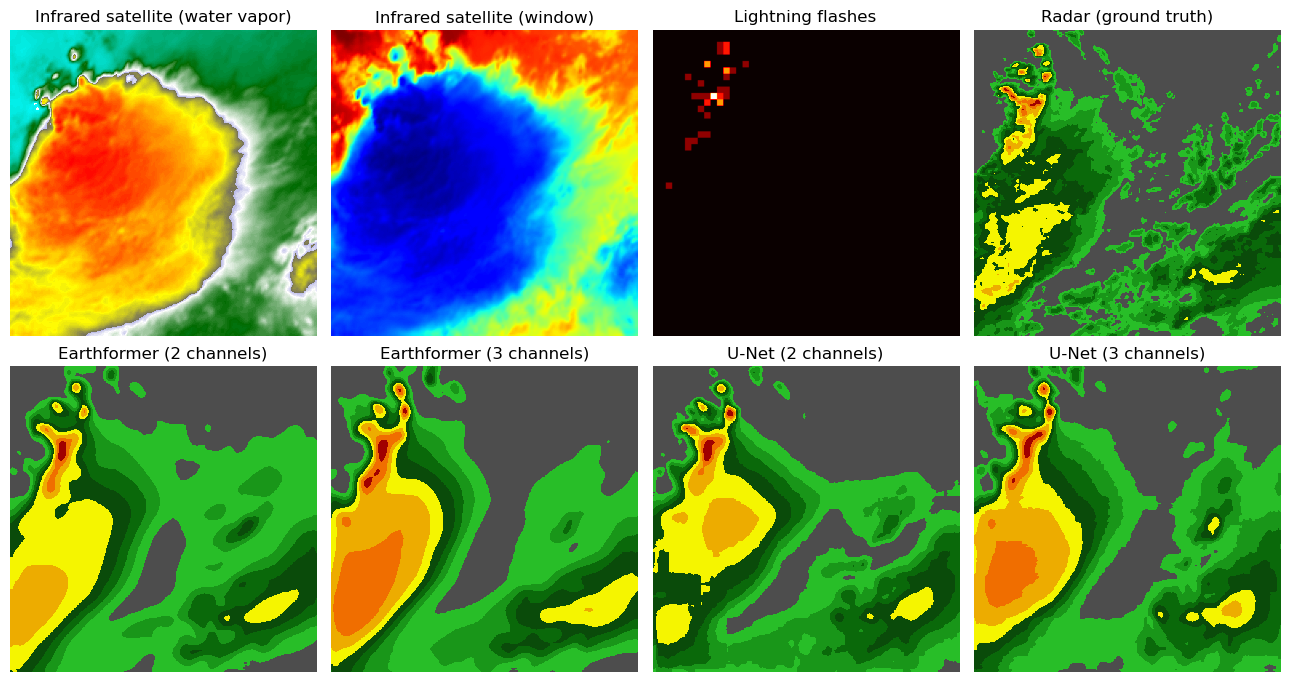

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(13, 7))

vis_cmap,vis_norm,vis_vmin,vis_vmax = get_cmap('vis',encoded=True)
ir069_cmap,ir069_norm,ir069_vmin,ir069_vmax = get_cmap('ir069',encoded=True)
ir107_cmap,ir107_norm,ir107_vmin,ir107_vmax = get_cmap('ir107',encoded=True)
vil_cmap,vil_norm,vil_vmin,vil_vmax = get_cmap('vil',encoded=True)
lght_cmap,lght_norm,lght_vmin,lght_vmax = get_cmap('lght',encoded=True)

axes[0, 0].imshow(inp2[0, :, :], cmap=ir069_cmap, norm=ir069_norm)
axes[0, 0].set_title("Infrared satellite (water vapor)")
axes[0, 0].axis("off")

axes[0, 1].imshow(inp2[1, :, :], cmap=ir107_cmap, norm=ir107_norm)
axes[0, 1].set_title("Infrared satellite (window)")
axes[0, 1].axis("off")

axes[0, 2].imshow(inp3[2, :, :], cmap=lght_cmap, norm=lght_norm)
axes[0, 2].set_title("Lightning flashes")
axes[0, 2].axis("off")

axes[0, 3].imshow(target2.squeeze(), cmap=vil_cmap)
axes[0, 3].set_title("Radar (ground truth)")
axes[0, 3].axis("off")

############################################################x

axes[1, 0].imshow(pred_ef2.squeeze(), cmap=vil_cmap)
axes[1, 0].set_title("Earthformer (2 channels)")
axes[1, 0].axis("off")

axes[1, 1].imshow(pred_ef3.squeeze(), cmap=vil_cmap)
axes[1, 1].set_title("Earthformer (3 channels)")
axes[1, 1].axis("off")

axes[1, 2].imshow(pred_unet2.squeeze(), cmap=vil_cmap)
axes[1, 2].set_title("U-Net (2 channels)")
axes[1, 2].axis("off")

axes[1, 3].imshow(pred_unet3.squeeze(), cmap=vil_cmap)
axes[1, 3].set_title("U-Net (3 channels)")
axes[1, 3].axis("off")

plt.tight_layout()

plt.show()
fig.savefig("examples.pdf")